In [23]:
"""
Complete Implementation for Imbalanced Classification Research

Author: Marwan eslam ouda
Date: December 2025
"""

'\nComplete Implementation for Imbalanced Classification Research\n\nAuthor: Marwan eslam ouda\nDate: December 2025\n'

In [24]:
!pip install imbalanced-learn xgboost pandas numpy scikit-learn matplotlib seaborn

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (f1_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             make_scorer)

# Imbalanced-learn imports
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# XGBoost
import xgboost as xgb

In [26]:
def load_diabetes_data():
    """Load Pima Indians Diabetes dataset"""

    from sklearn.datasets import load_diabetes


    df = pd.read_csv('/content/diabetes.csv')
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']

    return X, y, 'Diabetes'

def load_creditcard_data():
    """Load Credit Card Fraud dataset"""

    df = pd.read_csv('/content/creditcard.csv')


    df = df.sample(n=50000, random_state=42)

    X = df.drop(['Class', 'Time'], axis=1)
    y = df['Class']

    return X, y, 'Credit Card Fraud'

def load_heart_data():
    """Load Heart Disease dataset"""

    df = pd.read_csv('/content/heart.csv')
    X = df.drop('target', axis=1)
    y = df['target']

    return X, y, 'Heart Disease'

def get_all_datasets():
    """Load all datasets"""
    datasets = []

    try:
        X, y, name = load_diabetes_data()
        datasets.append((X, y, name))
        print(f"Loaded {name}: {X.shape[0]} samples, {y.sum()} positive ({y.sum()/len(y)*100:.1f}%)")
    except Exception as e:
        print(f" Failed to load Diabetes: {e}")

    try:
        X, y, name = load_creditcard_data()
        datasets.append((X, y, name))
        print(f" Loaded {name}: {X.shape[0]} samples, {y.sum()} positive ({y.sum()/len(y)*100:.1f}%)")
    except Exception as e:
        print(f" Failed to load Credit Card: {e}")

    try:
        X, y, name = load_heart_data()
        datasets.append((X, y, name))
        print(f" Loaded {name}: {X.shape[0]} samples, {y.sum()} positive ({y.sum()/len(y)*100:.1f}%)")
    except Exception as e:
        print(f" Failed to load Heart Disease: {e}")

    return datasets


In [27]:
def get_sampling_methods():
    """Define all sampling methods to test"""
    methods = {
        'Baseline': None,  # No resampling
        'Random_Over': RandomOverSampler(random_state=42),
        'Random_Under': RandomUnderSampler(random_state=42),
        'SMOTE': SMOTE(random_state=42, k_neighbors=5),
        'ADASYN': ADASYN(random_state=42, n_neighbors=5,sampling_strategy='auto')
    }
    return methods

def get_classifiers():
    """Define classifiers to test"""
    classifiers = {
        'Random_Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        )
    }
    return classifiers

In [28]:
class ImbalancedExperiment:
    """
    Main experiment class for running imbalanced classification experiments
    """

    def __init__(self, X, y, dataset_name):
        self.X = X
        self.y = y
        self.dataset_name = dataset_name
        self.results = []

        # Standardize features
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(X)

    def run_single_experiment(self, sampling_method, sampler,
                             classifier_name, classifier, n_folds=5):
        """
        Run a single experiment with given sampling method and classifier
        """
        print(f"  Running: {sampling_method} + {classifier_name}...", end=' ')

        # Initialize result as None
        result = None

        # Create pipeline
        if sampler is not None:
            pipeline = ImbPipeline([
                ('sampling', sampler),
                ('classifier', classifier)
            ])
        else:
            pipeline = classifier

        # Define scoring metrics
        scoring = {
            'f1': make_scorer(f1_score),
            'precision': make_scorer(precision_score, zero_division=0),
            'recall': make_scorer(recall_score, zero_division=0),
            'roc_auc': make_scorer(roc_auc_score)
        }

        # Cross-validation
        cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

        start_time = time.time()
        try:
            cv_results = cross_validate(
                pipeline,
                self.X_scaled,
                self.y,
                cv=cv,
                scoring=scoring,
                return_train_score=False,
                n_jobs=-1
            )
            training_time = time.time() - start_time

            # Store results
            result = {
                'Dataset': self.dataset_name,
                'Sampling_Method': sampling_method,
                'Classifier': classifier_name,
                'F1_Mean': cv_results['test_f1'].mean(),
                'F1_Std': cv_results['test_f1'].std(),
                'Precision_Mean': cv_results['test_precision'].mean(),
                'Precision_Std': cv_results['test_precision'].std(),
                'Recall_Mean': cv_results['test_recall'].mean(),
                'Recall_Std': cv_results['test_recall'].std(),
                'AUC_ROC_Mean': cv_results['test_roc_auc'].mean(),
                'AUC_ROC_Std': cv_results['test_roc_auc'].std(),
                'Training_Time': training_time
            }

            self.results.append(result)
            print(f"✓ F1={result['F1_Mean']:.3f}, AUC={result['AUC_ROC_Mean']:.3f}, Time={training_time:.1f}s")

        except Exception as e:
            # Create a result with NaN values for failed experiments
            result = {
                'Dataset': self.dataset_name,
                'Sampling_Method': sampling_method,
                'Classifier': classifier_name,
                'F1_Mean': np.nan,
                'F1_Std': np.nan,
                'Precision_Mean': np.nan,
                'Precision_Std': np.nan,
                'Recall_Mean': np.nan,
                'Recall_Std': np.nan,
                'AUC_ROC_Mean': np.nan,
                'AUC_ROC_Std': np.nan,
                'Training_Time': np.nan
            }
            self.results.append(result)
            print(f"✗ Skipped (Error: {str(e)[:50]}...)")

        return result

    def run_all_experiments(self):
        """
        Run experiments with all sampling methods and classifiers
        """
        print(f"\n{'='*70}")
        print(f"Dataset: {self.dataset_name}")
        print(f"Samples: {len(self.y)}, Features: {self.X.shape[1]}")

        # Calculate imbalance ratio
        minority_count = min((self.y == 0).sum(), (self.y == 1).sum())
        majority_count = max((self.y == 0).sum(), (self.y == 1).sum())
        imbalance_ratio = majority_count / minority_count

        print(f"Imbalance Ratio: {majority_count}:{minority_count} ({imbalance_ratio:.2f}:1)")
        print(f"{'='*70}\n")

        sampling_methods = get_sampling_methods()
        classifiers = get_classifiers()

        for samp_name, sampler in sampling_methods.items():
            # Skip ADASYN for nearly balanced datasets (ratio < 1.5:1)
            if samp_name == 'ADASYN' and imbalance_ratio < 1.5:
                print(f"  Skipping: {samp_name} (dataset too balanced, ratio={imbalance_ratio:.2f}:1)")
                continue

            for clf_name, clf in classifiers.items():
                self.run_single_experiment(
                    samp_name, sampler, clf_name, clf
                )

        return pd.DataFrame(self.results)

In [29]:
def run_complete_study():
    """
    Run the complete experimental study on all datasets
    """
    print("\n" + "="*70)
    print("IMBALANCED CLASSIFICATION COMPARATIVE STUDY")
    print("="*70)

    # Load datasets
    print("\nLoading datasets...")
    datasets = get_all_datasets()

    if not datasets:
        print("No datasets loaded! Please check data files.")
        return None

    # Run experiments on each dataset
    all_results = []

    for X, y, name in datasets:
        experiment = ImbalancedExperiment(X, y, name)
        results_df = experiment.run_all_experiments()
        all_results.append(results_df)

    # Combine all results
    final_results = pd.concat(all_results, ignore_index=True)

    # Save results
    final_results.to_csv('experimental_results.csv', index=False)
    print("\n✓ Results saved to 'experimental_results.csv'")

    return final_results

In [30]:
def plot_f1_comparison(results_df):
    """Plot F1-score comparison across methods"""
    plt.figure(figsize=(14, 6))

    # Remove rows with NaN values
    results_clean = results_df.dropna(subset=['F1_Mean'])

    # Prepare data
    pivot_data = results_clean.pivot_table(
        values='F1_Mean',
        index='Sampling_Method',
        columns=['Dataset', 'Classifier'],
        aggfunc='mean'
    )

    # Plot
    ax = pivot_data.plot(kind='bar', width=0.8)
    plt.title('F1-Score Comparison Across Methods, Datasets, and Classifiers',
              fontsize=14, fontweight='bold')
    plt.xlabel('Sampling Method', fontsize=12)
    plt.ylabel('F1-Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Dataset + Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('f1_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_performance_heatmap(results_df):
    """Plot heatmap of F1-scores"""
    plt.figure(figsize=(12, 8))

    # Remove NaN values and average across classifiers
    results_clean = results_df.dropna(subset=['F1_Mean'])

    pivot_data = results_clean.pivot_table(
        values='F1_Mean',
        index='Sampling_Method',
        columns='Dataset',
        aggfunc='mean'
    )

    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn',
                cbar_kws={'label': 'F1-Score'}, linewidths=0.5)
    plt.title('Average F1-Score Heatmap (Across Classifiers)',
              fontsize=14, fontweight='bold')
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Sampling Method', fontsize=12)
    plt.tight_layout()
    plt.savefig('performance_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_time_comparison(results_df):
    """Plot training time comparison"""
    plt.figure(figsize=(12, 6))

    # Remove NaN values
    results_clean = results_df.dropna(subset=['Training_Time'])

    # Group by sampling method and dataset
    time_data = results_clean.groupby(['Dataset', 'Sampling_Method'])['Training_Time'].mean().reset_index()

    sns.barplot(data=time_data, x='Sampling_Method', y='Training_Time', hue='Dataset')
    plt.title('Training Time Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Sampling Method', fontsize=12)
    plt.ylabel('Average Training Time (seconds)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Dataset')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('time_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_metric_comparison(results_df, dataset_name):
    """Plot all metrics for a specific dataset"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    data = results_df[results_df['Dataset'] == dataset_name]

    metrics = ['F1_Mean', 'Precision_Mean', 'Recall_Mean', 'AUC_ROC_Mean']
    titles = ['F1-Score', 'Precision', 'Recall', 'AUC-ROC']

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]

        pivot = data.pivot_table(
            values=metric,
            index='Sampling_Method',
            columns='Classifier',
            aggfunc='mean'
        )

        pivot.plot(kind='bar', ax=ax, width=0.8)
        ax.set_title(f'{title} - {dataset_name}', fontweight='bold')
        ax.set_xlabel('Sampling Method')
        ax.set_ylabel(title)
        ax.legend(title='Classifier')
        ax.grid(axis='y', alpha=0.3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f'metrics_{dataset_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_all_visualizations(results_df):
    """Generate all visualizations"""
    print("\nGenerating visualizations...")

    plot_f1_comparison(results_df)
    plot_performance_heatmap(results_df)
    plot_time_comparison(results_df)

    # Individual dataset plots
    for dataset_name in results_df['Dataset'].unique():
        plot_metric_comparison(results_df, dataset_name)

    print("✓ All visualizations saved!")

In [31]:
def perform_statistical_analysis(results_df):
    """Perform statistical analysis and ranking"""
    print("\n" + "="*70)
    print("STATISTICAL ANALYSIS")
    print("="*70 + "\n")

    # Remove NaN values
    results_clean = results_df.dropna(subset=['F1_Mean'])

    # Overall best methods
    print("Top 5 Methods by Average F1-Score:")
    top_methods = results_clean.groupby('Sampling_Method')['F1_Mean'].mean().sort_values(ascending=False)
    for i, (method, score) in enumerate(top_methods.head().items(), 1):
        print(f"{i}. {method}: {score:.4f}")

    print("\n" + "-"*70 + "\n")

    # Best per dataset
    print("Best Method per Dataset:")
    for dataset in results_clean['Dataset'].unique():
        data = results_clean[results_clean['Dataset'] == dataset]
        if len(data) > 0:
            best = data.loc[data['F1_Mean'].idxmax()]
            print(f"\n{dataset}:")
            print(f"  Method: {best['Sampling_Method']} + {best['Classifier']}")
            print(f"  F1: {best['F1_Mean']:.4f} (±{best['F1_Std']:.4f})")
            print(f"  AUC-ROC: {best['AUC_ROC_Mean']:.4f}")

    print("\n" + "="*70)



IMBALANCED CLASSIFICATION COMPARATIVE STUDY

Loading datasets...
Loaded Diabetes: 768 samples, 268 positive (34.9%)
 Loaded Credit Card Fraud: 50000 samples, 83 positive (0.2%)
 Loaded Heart Disease: 1025 samples, 526 positive (51.3%)

Dataset: Diabetes
Samples: 768, Features: 8
Imbalance Ratio: 500:268 (1.87:1)

  Running: Baseline + Random_Forest... ✓ F1=0.647, AUC=0.731, Time=5.3s
  Running: Baseline + XGBoost... ✓ F1=0.623, AUC=0.714, Time=1.0s
  Running: Random_Over + Random_Forest... ✓ F1=0.674, AUC=0.749, Time=3.6s
  Running: Random_Over + XGBoost... ✓ F1=0.631, AUC=0.716, Time=0.7s
  Running: Random_Under + Random_Forest... ✓ F1=0.681, AUC=0.752, Time=1.8s
  Running: Random_Under + XGBoost... ✓ F1=0.672, AUC=0.746, Time=0.6s
  Running: SMOTE + Random_Forest... ✓ F1=0.662, AUC=0.738, Time=1.2s
  Running: SMOTE + XGBoost... ✓ F1=0.648, AUC=0.727, Time=0.5s
  Running: ADASYN + Random_Forest... ✓ F1=0.680, AUC=0.752, Time=1.1s
  Running: ADASYN + XGBoost... ✓ F1=0.636, AUC=0.717, 

<Figure size 1400x600 with 0 Axes>

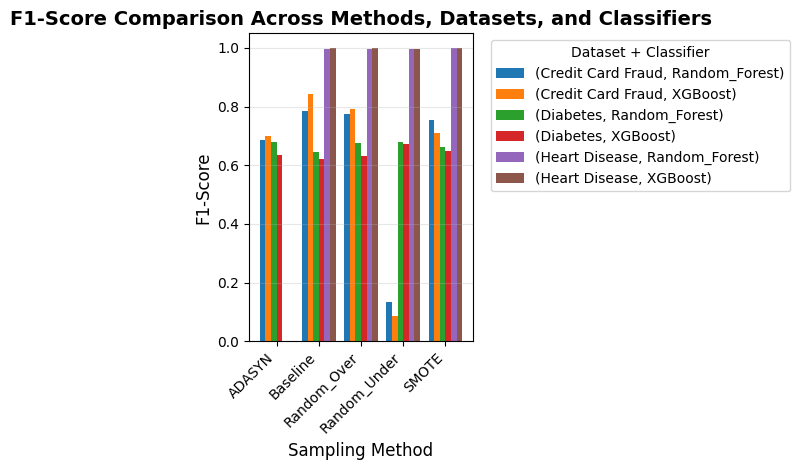

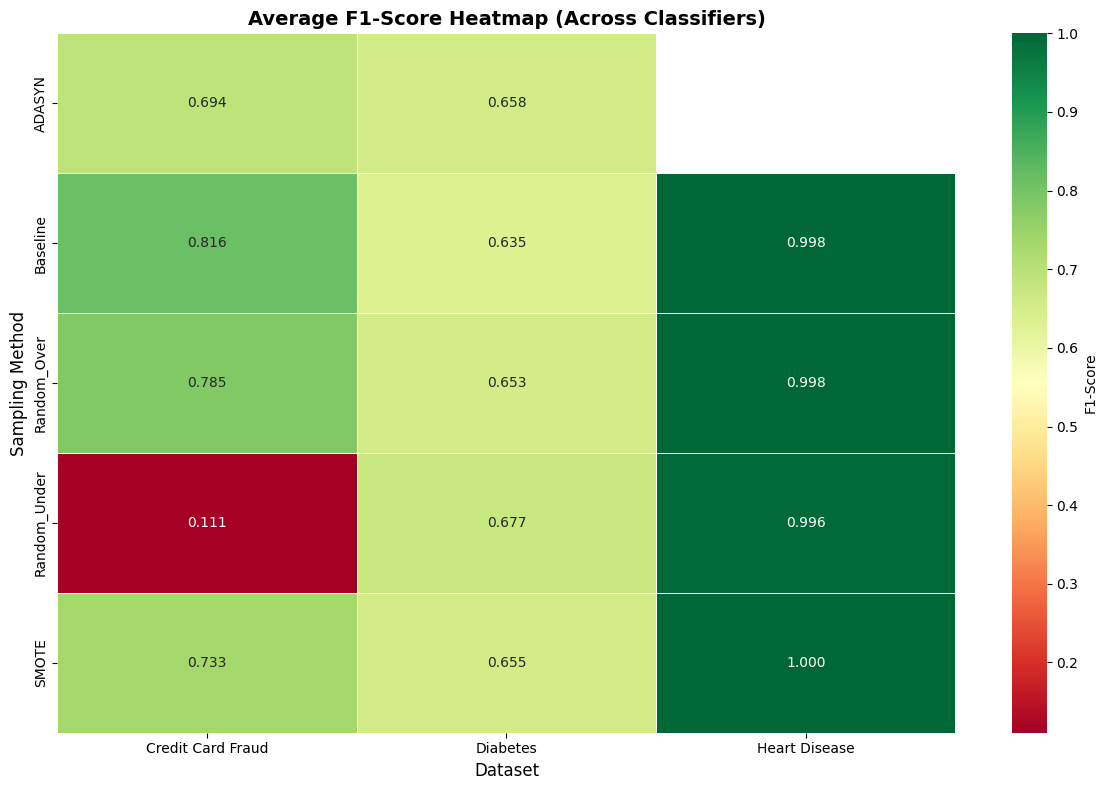

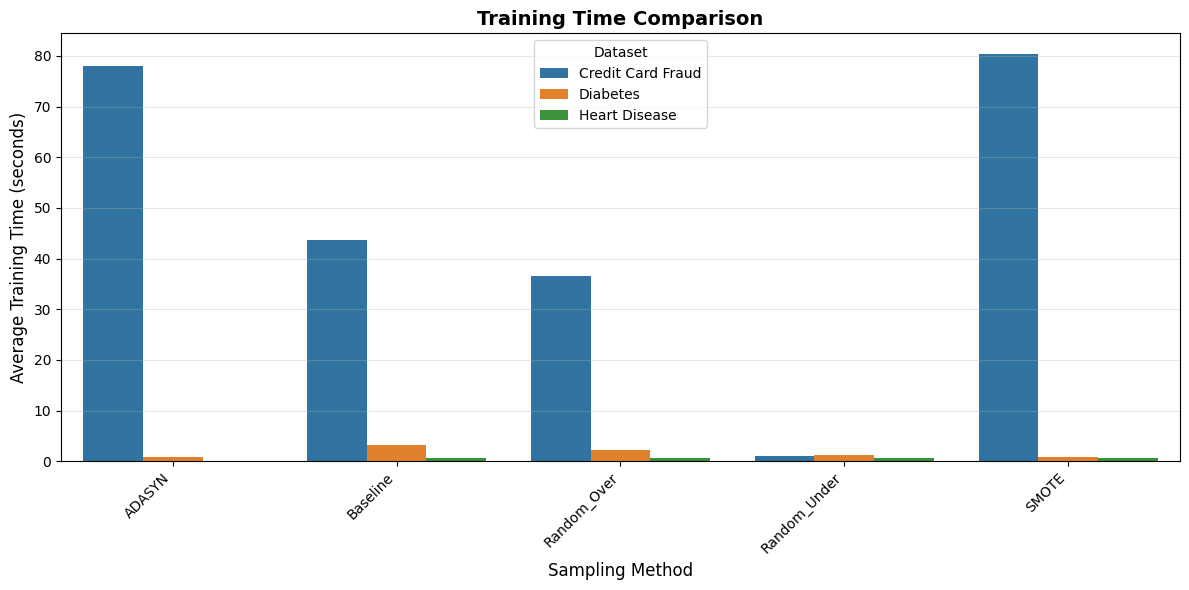

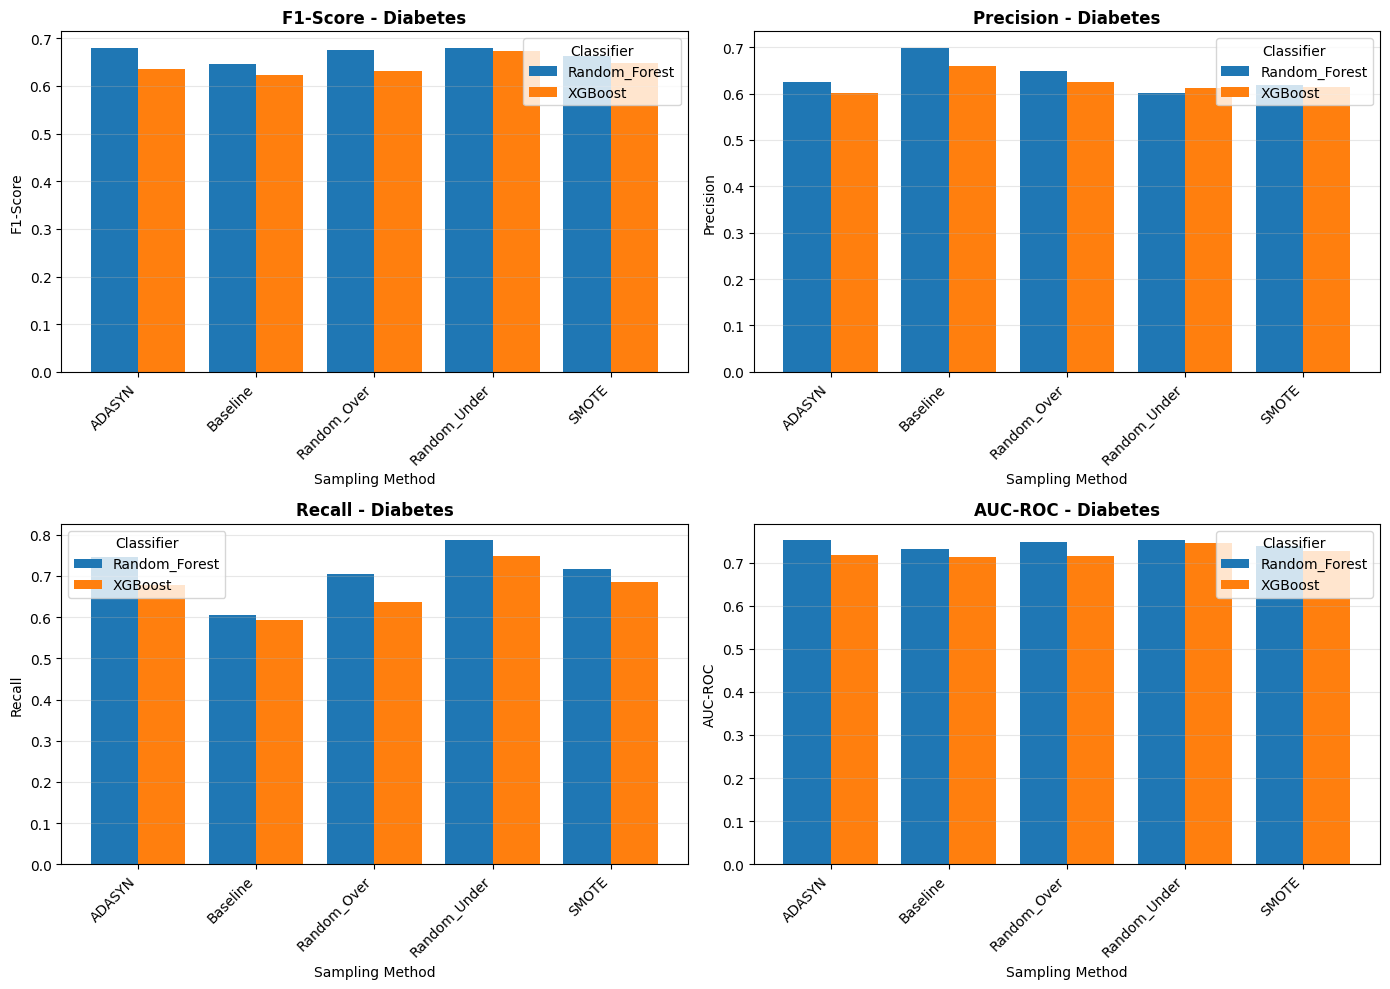

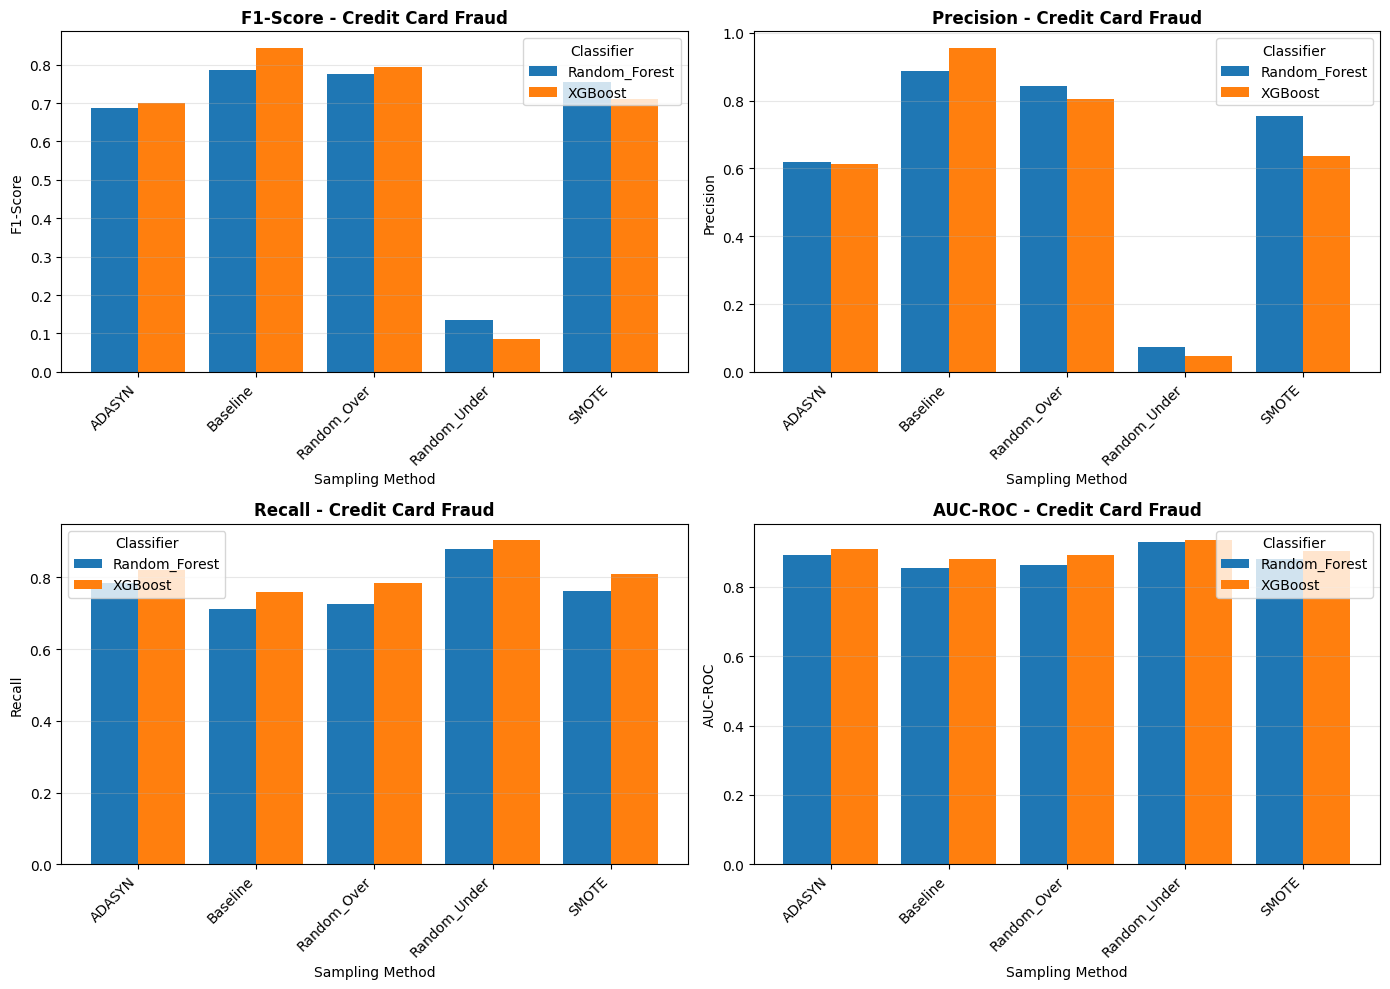

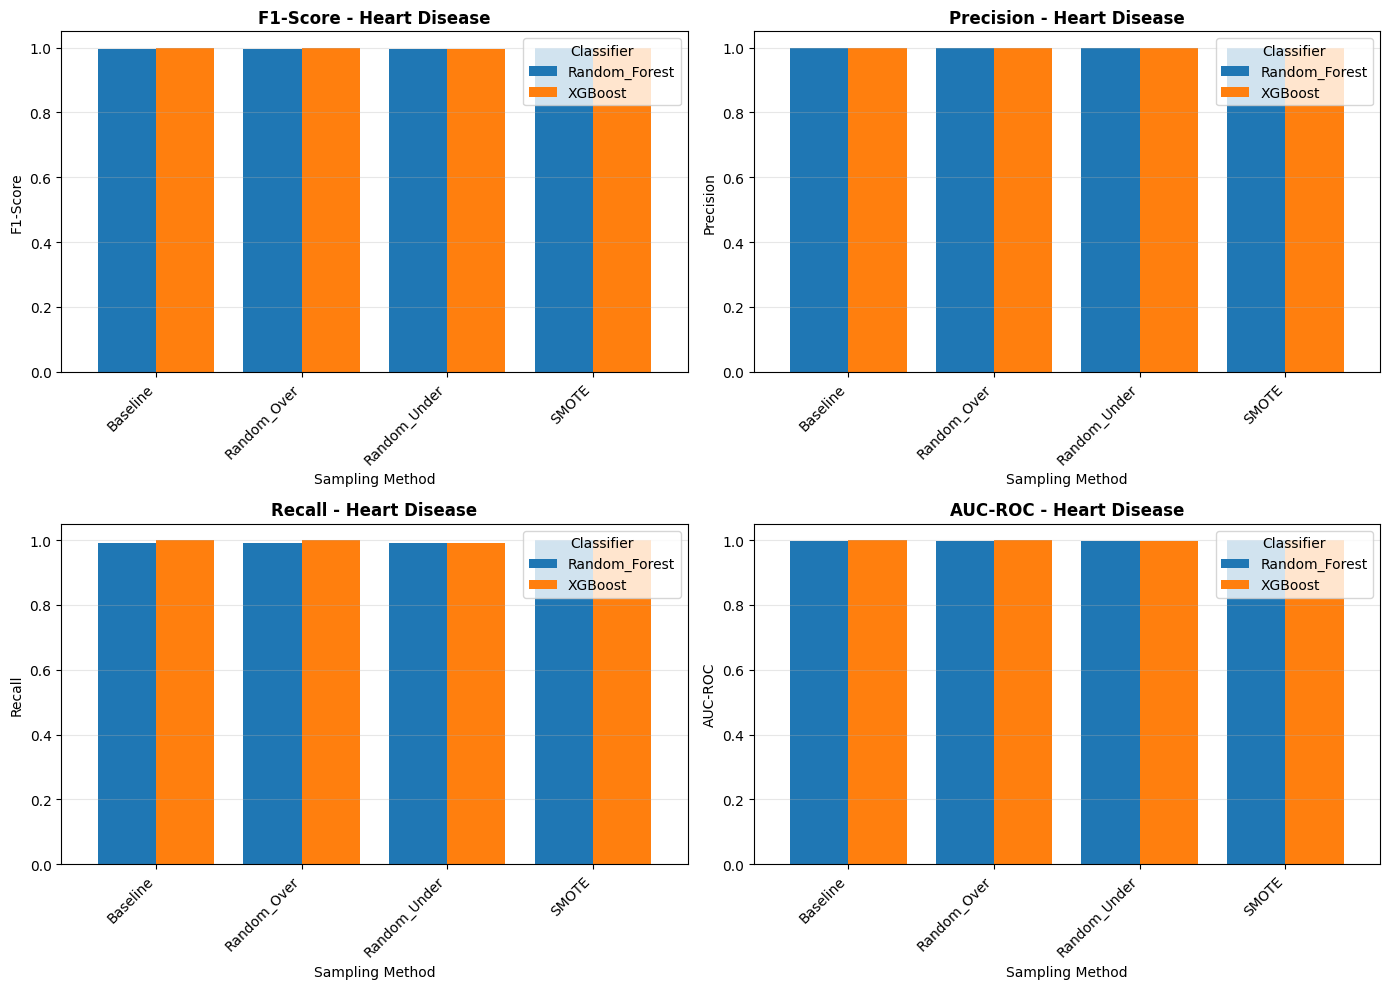

✓ All visualizations saved!

STATISTICAL ANALYSIS

Top 5 Methods by Average F1-Score:
1. Baseline: 0.8163
2. Random_Over: 0.8118
3. SMOTE: 0.7960
4. ADASYN: 0.6760
5. Random_Under: 0.5944

----------------------------------------------------------------------

Best Method per Dataset:

Diabetes:
  Method: Random_Under + Random_Forest
  F1: 0.6807 (±0.0430)
  AUC-ROC: 0.7516

Credit Card Fraud:
  Method: Baseline + XGBoost
  F1: 0.8446 (±0.0437)
  AUC-ROC: 0.8794

Heart Disease:
  Method: Baseline + XGBoost
  F1: 1.0000 (±0.0000)
  AUC-ROC: 1.0000


SUMMARY RESULTS

                                                 F1_Mean  AUC_ROC_Mean  \
Dataset           Sampling_Method Classifier                             
Credit Card Fraud ADASYN          Random_Forest   0.6874        0.8915   
                                  XGBoost         0.7007        0.9095   
                  Baseline        Random_Forest   0.7869        0.8554   
                                  XGBoost         0.8446  

In [32]:
if __name__ == "__main__":
    # Run complete study
    results = run_complete_study()

    if results is not None:
        # Generate visualizations
        generate_all_visualizations(results)

        # Perform statistical analysis
        perform_statistical_analysis(results)

        # Display summary table
        print("\n" + "="*70)
        print("SUMMARY RESULTS")
        print("="*70 + "\n")
        print(results.groupby(['Dataset', 'Sampling_Method', 'Classifier'])[
            ['F1_Mean', 'AUC_ROC_Mean', 'Training_Time']
        ].mean().round(4))

        print("\n✓ Experiment Complete! Check output files for detailed results.")